### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 2
### Due: Saturday, Jan 25th at 11.59pm CST
---

## Problem 1

This question is about Monte Carlo integration. A standard Gaussian integral takes the form 

$$ \int_0^\infty x^3 \exp\left(-\frac{x^2}{2\sigma^2}\right) \,dx$$

1) What does this integral analytically evaluate to? (Should involve $\sigma$.) Once you work this equation out, we will refer to this equality of the integral and analytic value as EQ1. 

2) Write down the standard form of a Gaussian distribution with $\mu=0$ and $\sigma=\sigma$ that is normalized between $\infty$ and $+\infty$. What is the corresponding form of a half-Gaussian distribution between $0$ and $+\infty$? (Remember that the half-Gaussian distribution must be normalized such that it integrates to one.)

3) Manipulate EQ1 such that you can write the integral in terms of a function of $x$ weighted by a normalized half-Gaussian distribution. 

4) Draw $N=10^5$ samples from a $\sigma=2$ normal distribution, mask the samples such that only positive values are accepted, then perform Monte Carlo integration using your new equation involving a half-Gaussian distribution from (3). Confirm that this *approximately* matches the value computed from the right hand side of the equation. If you don't get approximately matching values then you may have forgotten normalization factors for the Gaussian, or constant factors from translating a normalized Gaussian to a half-Gaussian.

5) Repeat (3) for $N=[10^2,10^3,10^4]$, computing the integral using $100$ different batches of random samples for each $N$. Record all calculated values at all $N$. 

6) Make a plot that shows $\log_{10}N$ along the $x$-axis and the spread between the maximum and minimum Monte Carlo integral values that you get at each $N$ on the $y$-axis. (Note: matplotlib's `fill_between` command is useful for this). Plot a horizontal line on the same figure to show the precise mathematical value. You should see that Monte Carlo integration results in less numerical spread as $N$ gets larger.

In [1]:
# Execute this cell
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from scipy import optimize
from astroML import stats as astroMLstats
from astroML.datasets import fetch_hogg2010test

### Solution

SRT: Part 1's analytic derivation is perfect. Part 2 is almost fine except that it should have `sigma^2` in the pre-factor's denomiator rather than `sigma`, and the mean should be zero, as the question states. -2 point

In [44]:
mu=0
sigma = 1.0  # Standard deviation
num_samples = 1000000  # Number of Monte Carlo samples
gaus = norm(loc=mu, scale=sigma)
samples = np.random.normal(loc=0, scale=sigma, size=num_samples)
positive_samples = samples[samples > 0]  # Mask for positive values

def analytical_value(sigma):
    return 2 * sigma**4

def half_gaussian_pdf(x, sigma):
    return (2 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-x**2 / (2 * sigma**2))

pdf=half_gaussian_pdf(num_samples, sigma)
integral_monte_carlo = np.mean(pdf)

posSamp=samples[samples > 0] 
mcResult=np.mean(posSamp**3) * np.sqrt(2 / np.pi)



SRT: The question states that `sigma=2`, not `1`. -2 points

Also, why did you include a step to average over the pdf values? The folllowing step was fine, because the point of Monte Carlo integration is to use random samples from a distribution to integrate over a function, which in this case is proportional to `x^3`.

In [50]:
analytical = analytical_value(sigma)
print(f"Monte Carlo Result: {mcResult}")
print(f"Analytical Value: {analytical}")
print(f"Relative Error: {abs(mcResult - analytical) / analytical * 100:.2f}%")

Monte Carlo Result: 1.2747707028153599
Analytical Value: 2.0
Relative Error: 36.26%


SRT: OK, assuming `sigma=1` and following through, your solution does not match the analytic value because the normalization above is incorrect. Instead of multiplying by `np.sqrt(2 / np.pi)` it should be `sigma * np.sqrt(np.pi / 2)`. -2 points

In [52]:
n_values = [10**3, 10**4, 10**5, 10**6]
results = []
errors = []

for n in n_values:
    batch_results = []
    for _ in range(10):  # 10 different batches for each n
        samples = gaus.rvs(size=n)
        positive_samples = samples[samples > 0]
        batch_result = np.mean(positive_samples**3) * np.sqrt(2 / np.pi)
        batch_results.append(batch_result)
    results.append(batch_results)
    errors.append((np.max(batch_results), np.min(batch_results)))

SRT: The question asks for `100` batches at each N. -1 point

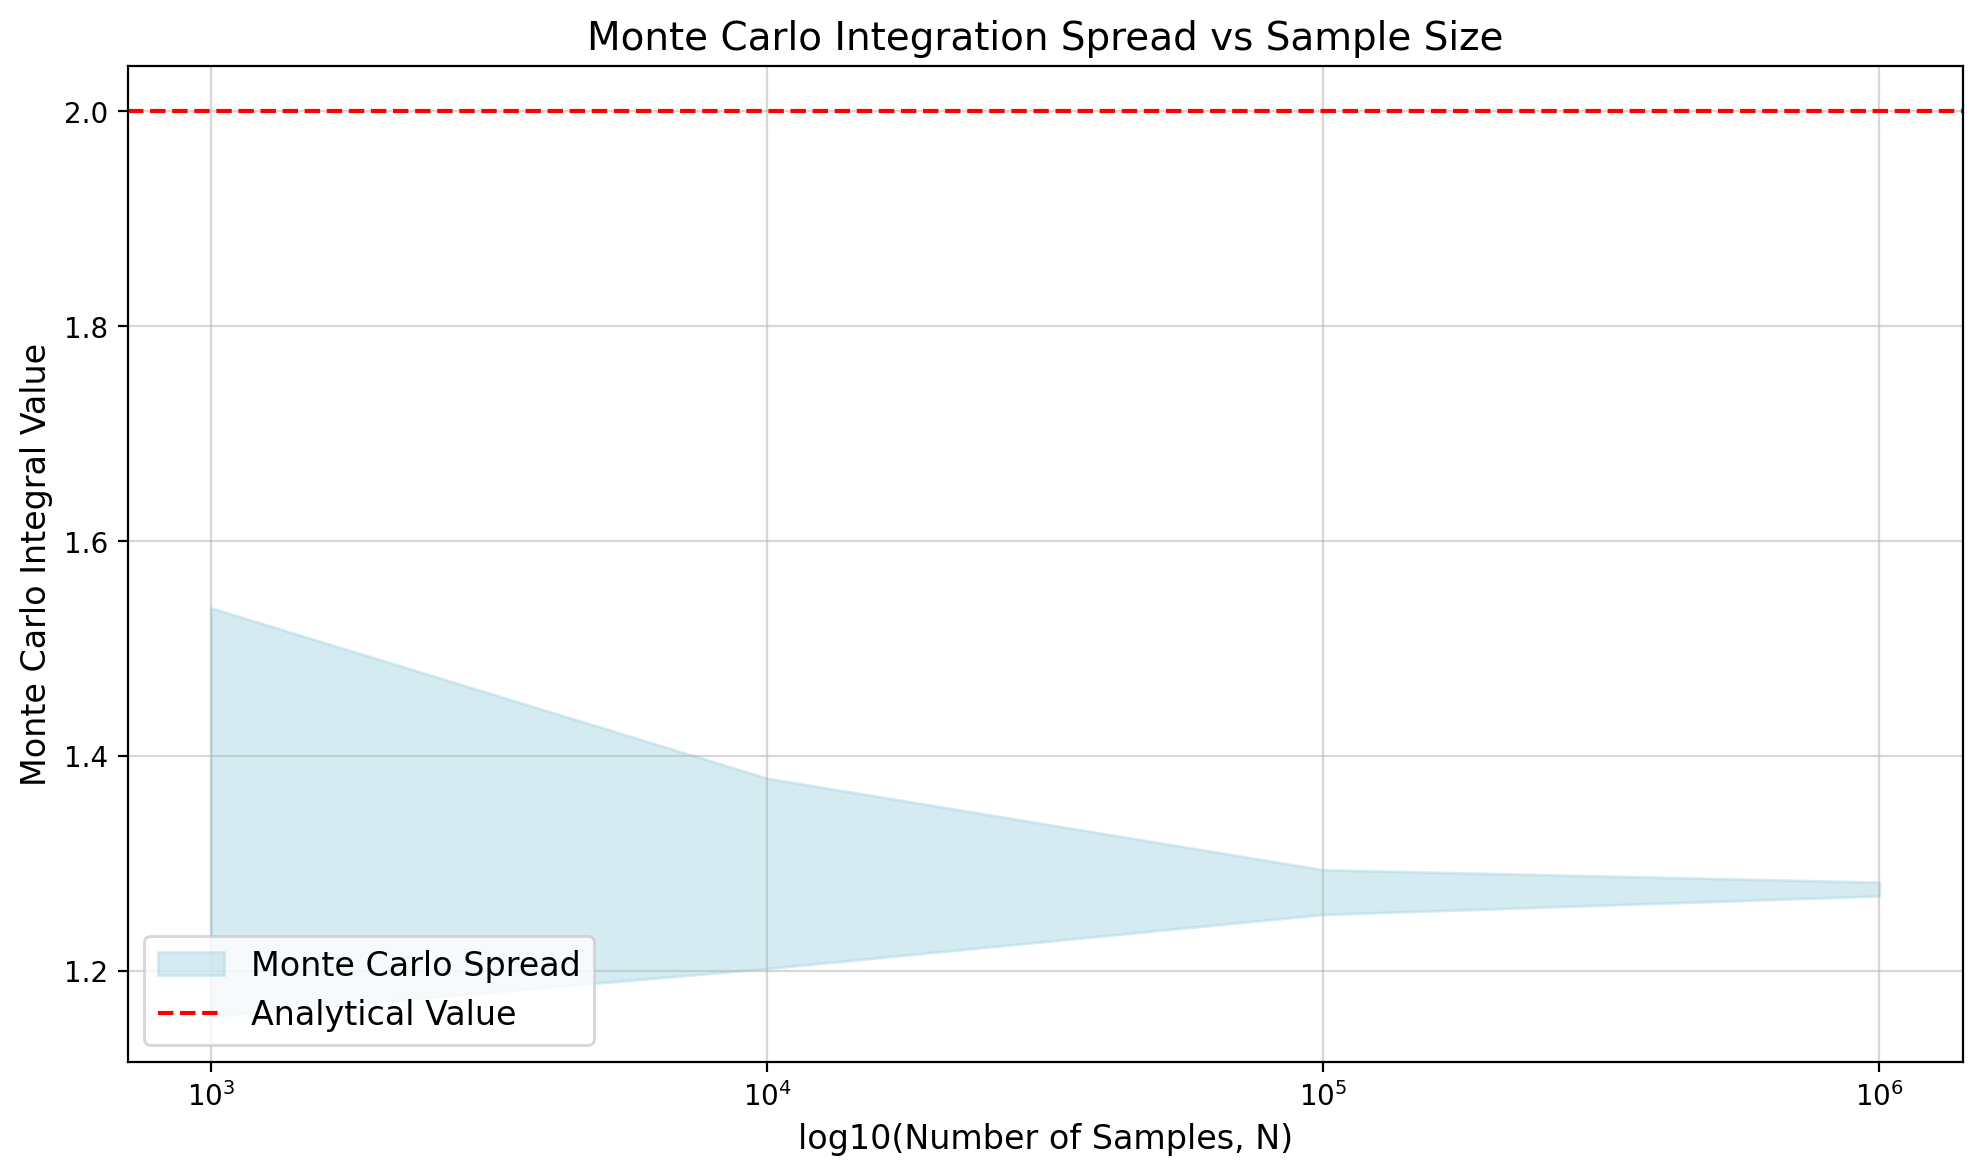

Monte Carlo Integration Results:
N = 1000: Max = 1.53750, Min = 1.15739, Spread = 0.38011
N = 10000: Max = 1.37894, Min = 1.20194, Spread = 0.17700
N = 100000: Max = 1.29376, Min = 1.25221, Spread = 0.04155
N = 1000000: Max = 1.28219, Min = 1.26948, Spread = 0.01271


In [56]:
# Step 6: Improved Plot for Monte Carlo Spread vs Sample Size
n_log = np.log10(n_values)  # Logarithm of sample sizes for x-axis
max_errors = [e[0] for e in errors]  # Maximum values from batches
min_errors = [e[1] for e in errors]  # Minimum values from batches
spread = [max_err - min_err for max_err, min_err in zip(max_errors, min_errors)]  # Spread calculation

plt.figure(figsize=(10, 6))

# Fill between min and max Monte Carlo values
plt.fill_between(
    n_log, 
    min_errors, 
    max_errors, 
    color="lightblue", 
    alpha=0.5, 
    label="Monte Carlo Spread"
)

# Horizontal line for the analytical value
plt.axhline(analytical, color="red", linestyle="--", label="Analytical Value")

# Customize plot for better appearance
plt.title("Monte Carlo Integration Spread vs Sample Size", fontsize=14)
plt.xlabel("log10(Number of Samples, N)", fontsize=12)
plt.ylabel("Monte Carlo Integral Value", fontsize=12)
plt.xticks(n_log, [f"$10^{{{int(log)}}}$" for log in n_log], fontsize=10)  # Format x-axis ticks
plt.legend(fontsize=12)
plt.grid(alpha=0.5)

# Show the plot
plt.tight_layout()
plt.show()

# Print details for each N
print("Monte Carlo Integration Results:")
for i, n in enumerate(n_values):
    print(f"N = {n}: Max = {max_errors[i]:.5f}, Min = {min_errors[i]:.5f}, Spread = {spread[i]:.5f}")


SRT: Pretty good! If you had gotten the normalization pre-factor correct then I think this would actually converge to the analytic value. But no commentary on the fact that it does not match the analytic value? -1 point.

## Problem 2

This question is about IQ. It's a flawed and questionable metric, but useful for this problem. By definition, IQ is calibrated as a Gaussian distribution with $\mu=100$ and $\sigma=15$. 

1) Create a `scipy.stats` Gaussian object with these properties. Plot the distribution, and print out 10 random draws, along with the pdf at $x=150$. 

2) Access the `cdf` property of the Gaussian object and plot it over the same $x$-range as in (1) but in a different figure. Access the `ppf` property (percent point function) and use *inverse transform sampling* of the cdf to draw $10^5$ random samples, and make a histogram of these. Overplot the pdf from (1). These should match.

3) What fraction of people have IQ > 150? *Hint: investigate all the properties of the Gaussian object from (1) to find the relevant property that gives you this, or perform a calculation involving the cdf.*

4) What IQ corresponds to "one in a million"?

### Solution

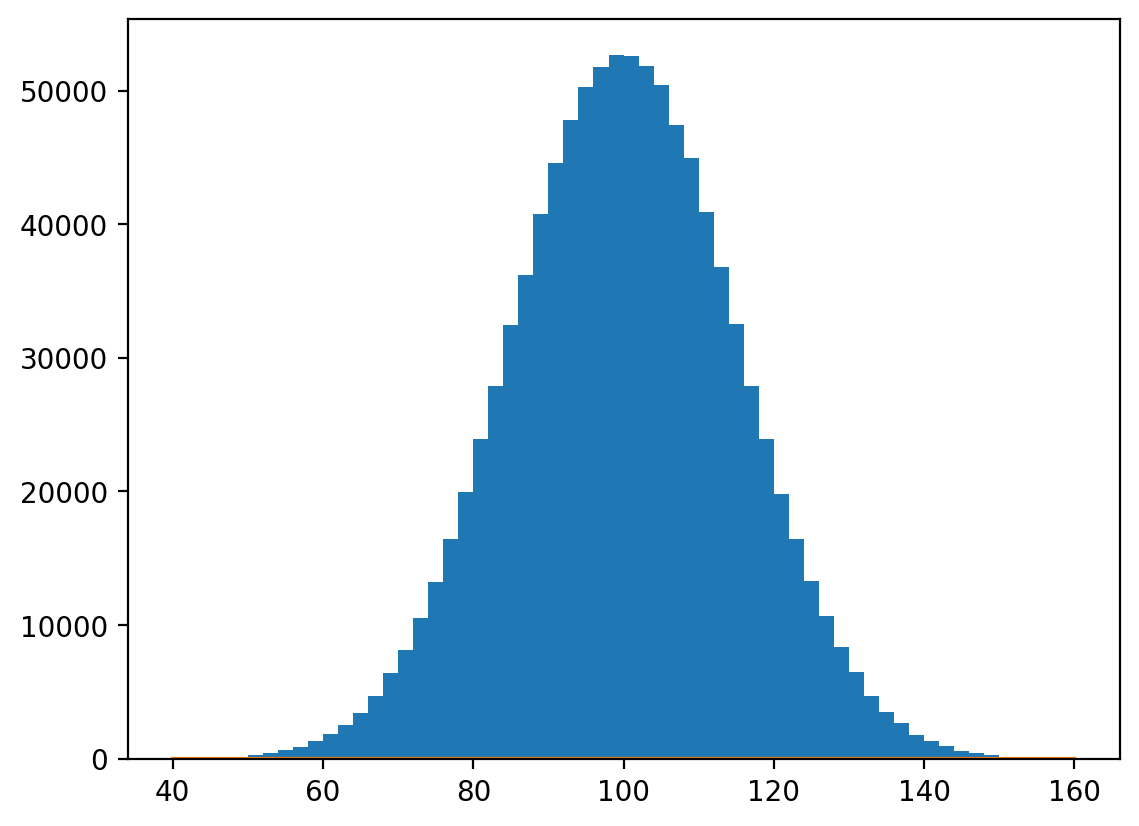

In [27]:
from scipy.stats import norm
#1
mu=100
sigma=15
gaus= norm(loc=mu, scale=sigma)
n=10**6
acc=150
accepted=[]

xmin= mu-4*sigma
xmax=mu+4*sigma
x=np.linspace(xmin,xmax,1000)
pdf=gaus.pdf(x)

#




SRT: What is this a plot of? There is no plot command in the cell above. 

Number of accepted samples: 1998347
First 10 accepted samples: [103.28805857325543, 123.04417639280386, 111.33928532996349, 119.93200258927419, 103.14812853319862, 104.28512617362969, 89.82488716585432, 87.58252766340762, 127.55477672514274, 124.3934780241062]


(array([   534.,    792.,   1248.,   1749.,   2616.,   3663.,   5064.,
          6903.,   9492.,  12597.,  16580.,  21039.,  26566.,  32743.,
         40001.,  47688.,  55807.,  64562.,  72947.,  81468.,  88549.,
         95129., 100645., 104065., 105737., 106230., 103672., 100676.,
         95086.,  89317.,  81726.,  73110.,  64921.,  56084.,  47618.,
         40106.,  32795.,  26531.,  21134.,  16436.,  12772.,   9511.,
          6945.,   5124.,   3572.,   2551.,   1813.,   1145.,    784.,
           504.]),
 array([ 50.0000006 ,  51.99996468,  53.99992875,  55.99989283,
         57.99985691,  59.99982099,  61.99978506,  63.99974914,
         65.99971322,  67.9996773 ,  69.99964137,  71.99960545,
         73.99956953,  75.99953361,  77.99949768,  79.99946176,
         81.99942584,  83.99938992,  85.99935399,  87.99931807,
         89.99928215,  91.99924623,  93.99921031,  95.99917438,
         97.99913846,  99.99910254, 101.99906662, 103.99903069,
        105.99899477, 107.99895885, 

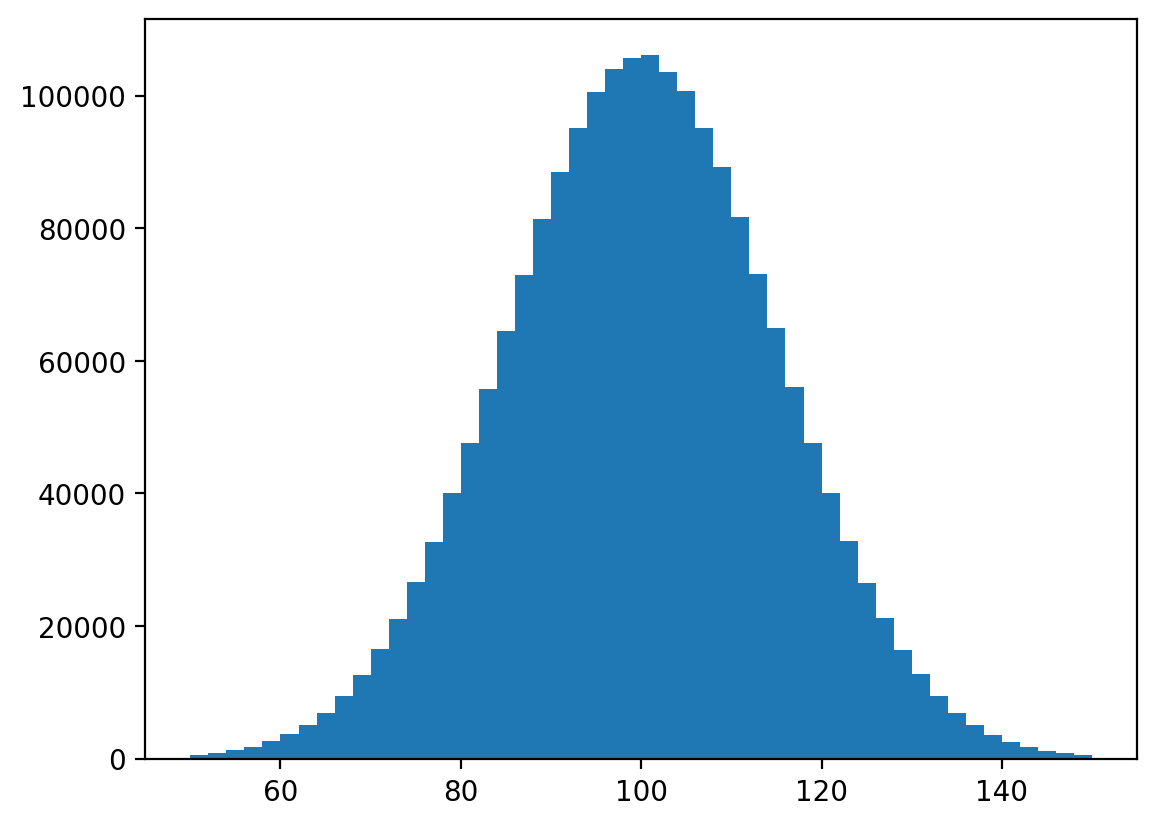

In [33]:

samp=gaus.rvs(size=n) # gets random samples

for i in samp:
    if gaus.pdf(i)>=gaus.pdf(acc):
        accepted.append(i)#adds all iq vals higher than 150
len_accepted = len(accepted)  # Total number of accepted samples

print(f"Number of accepted samples: {len_accepted}")
if len_accepted > 0:
    print(f"First 10 accepted samples: {accepted[:10]}")
else:
    print("No samples were accepted.")

plt.hist(accepted, bins=50)

SRT: I'm not sure what's happening in this cell. It appears to be trying acceptance/rejection of samples. But since you create a scipy.stats Gaussian object, you can simply draw 10 random samples using `gaus.rvs(size=10).

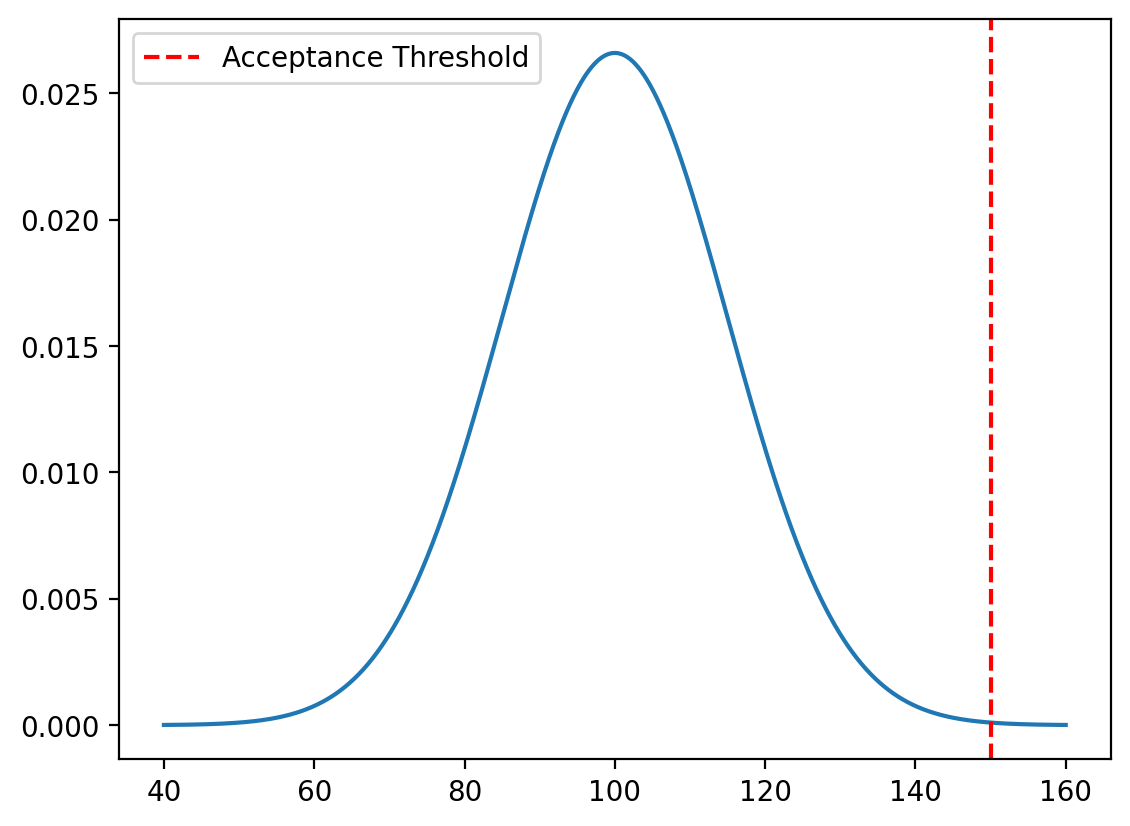

In [37]:

plt.plot(x,pdf)
plt.axvline(x=acc, color="red", linestyle="--", label="Acceptance Threshold")
plt.legend()


SRT: OK, this has the proper plot of the pdf on an x-axis. But most of the question remains unanswered. -12 points

## Problem 3

This question is about Poisson distributions. A famous early application was an analysis of Prussian cavalryman horse-kick deaths by [Bortkiewicz](https://www.wikiwand.com/en/Ladislaus_Bortkiewicz) in 1898. Let's take a short look at the kind of data he analyzed.

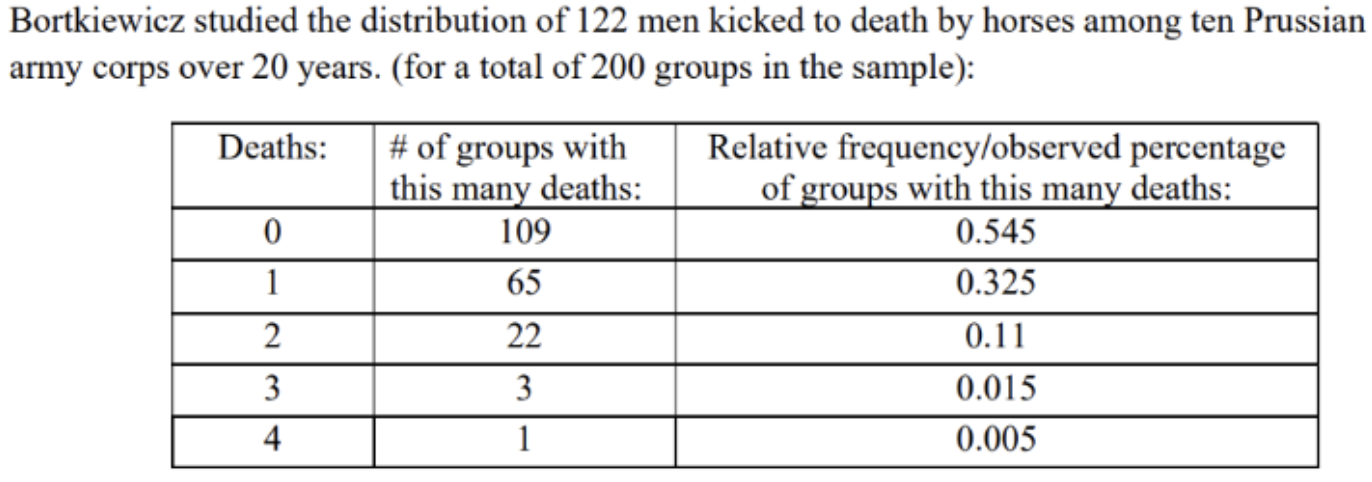

The data essentially consist of 200 total years of Prussian army corps information (i.e. ten army corps over 20 years).

1) Make a plot of the first and third columns of this data.

2) Plot a few Poisson distributions on top that are characterized by different $\mu$ values that might be reasonable guesses for how the data is distributed.

3) We'll come to model fitting soon, but for now use the descriptive sample statistics that you can calculate from this data to deduce the $\mu$ of the modeled Poisson distribution, e.g. the mean, std, median, mode, skewness, and kurtosis, where relevant. Do this however you like, but note that with the data in the table you won't just be able to get a sample mean, since these are tabulated densities, not samples. 

*Hint: use a weighted mean, or alternatively make a dataset that has the numbers 0,1,2,3,4 in agreement with their frequency in the table.*

4) Plot the Poisson distribution with the $\mu$ found in (3) alongside the data.

### Solution

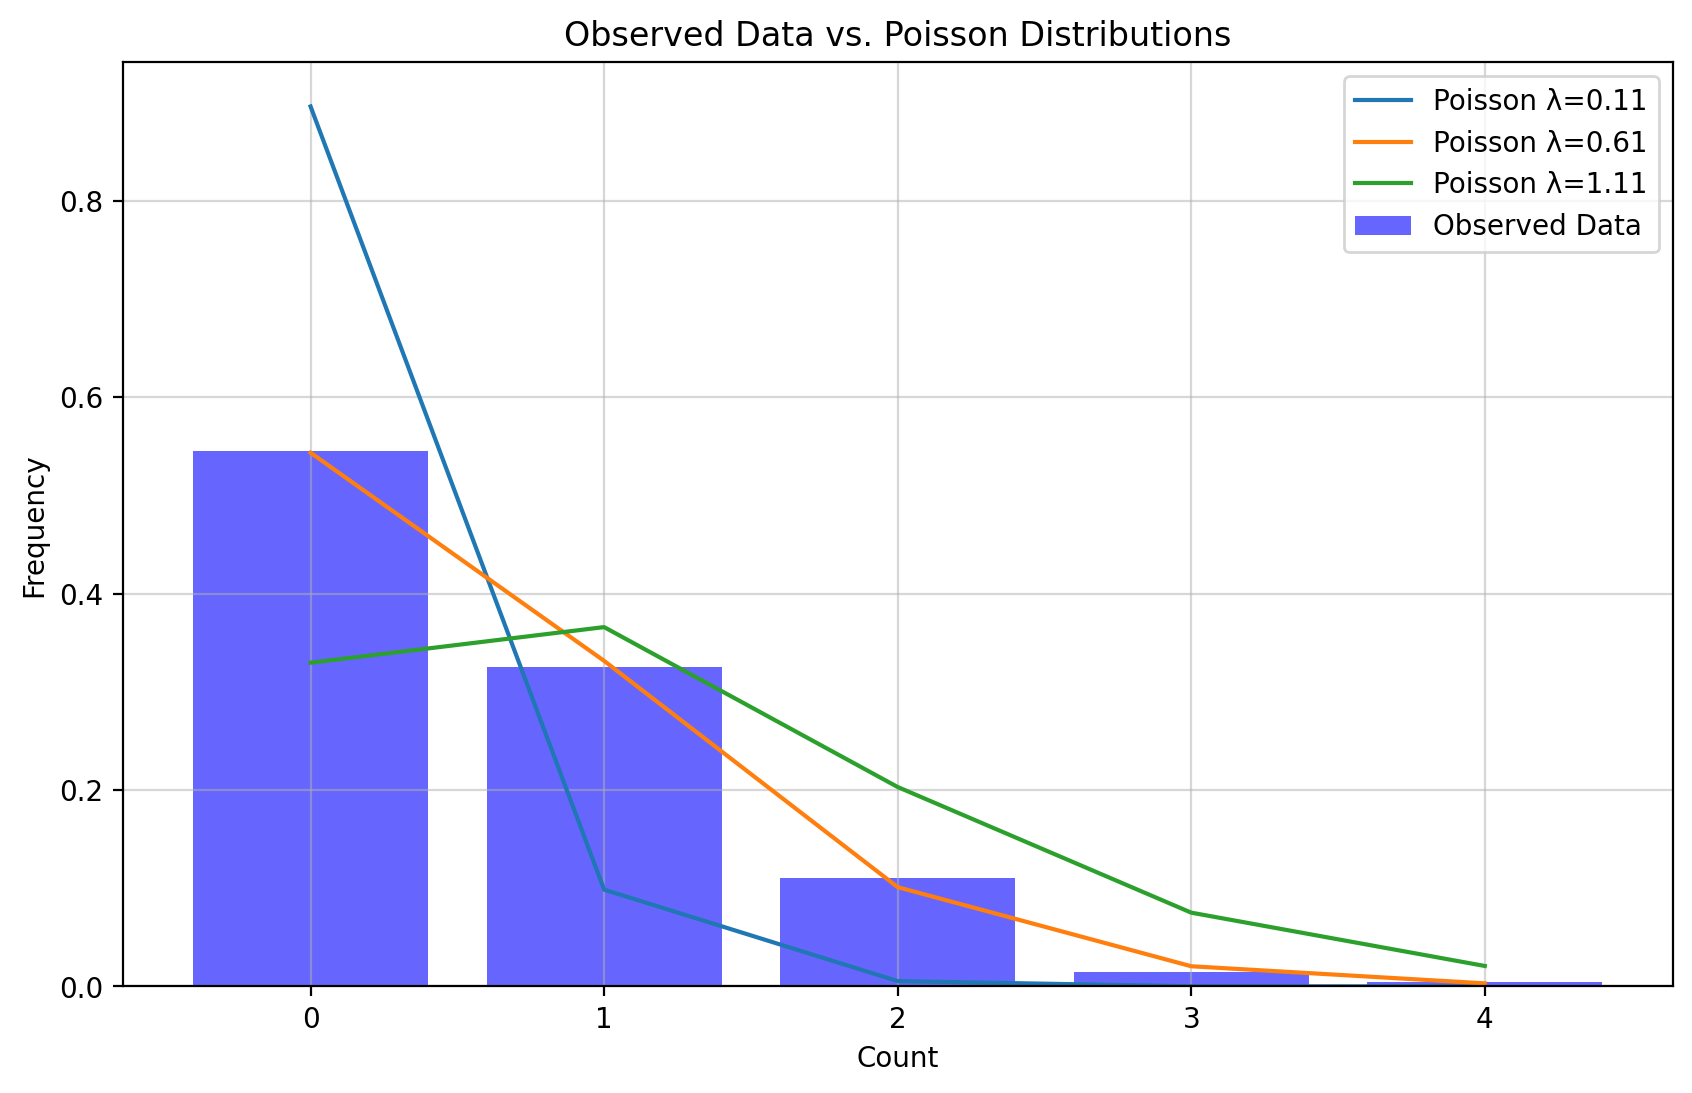

Descriptive Statistics:
Weighted Mean (λ): 0.61
Weighted Variance: 0.61
Standard Deviation: 0.78


In [58]:

from scipy.stats import poisson

# Step 1: Define the data (replace this with your actual dataset)
# Assume the first column represents counts (0, 1, 2, ...) and the third column represents frequencies.
data = np.array([
    [0, 109, .545],  # Example data: count 0 occurs 10 times
    [1, 65, .325],  # count 1 occurs 20 times
    [2, 22, .11],  # count 2 occurs 30 times
    [3, 3, .015],  # count 3 occurs 25 times
    [4, 1, .005],  # count 4 occurs 15 times
])
counts = data[:, 0]  # First column: counts (0, 1, 2, ...)
frequencies = data[:, 2]  # Third column: frequencies

# Step 2: Compute sample statistics
# Weighted mean (lambda for the Poisson distribution)
weighted_mean = np.sum(counts * frequencies) / np.sum(frequencies)

# Weighted variance
weighted_variance = np.sum(frequencies * (counts - weighted_mean) ** 2) / np.sum(frequencies)

# Standard deviation
std_dev = np.sqrt(weighted_variance)

# Step 3: Plot the data
plt.figure(figsize=(10, 6))

# Plot the observed data as a bar chart
plt.bar(counts, frequencies, alpha=0.6, color="blue", label="Observed Data")

# Plot Poisson distributions with different lambda values
lambda_values = [weighted_mean - 0.5, weighted_mean, weighted_mean + 0.5]
x = np.arange(0, max(counts) + 1)

for lam in lambda_values:
    poisson_probs = poisson.pmf(x, lam) * np.sum(frequencies)  # Scale to match data
    plt.plot(x, poisson_probs, label=f"Poisson λ={lam:.2f}")

# Labels and legend
plt.title("Observed Data vs. Poisson Distributions")
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.legend()
plt.grid(alpha=0.5)
plt.show()

# Step 4: Print descriptive statistics
print("Descriptive Statistics:")
print(f"Weighted Mean (λ): {weighted_mean:.2f}")
print(f"Weighted Variance: {weighted_variance:.2f}")
print(f"Standard Deviation: {std_dev:.2f}")


SRT: Your solution code begins with a comment: `# Step 1: Define the data (replace this with your actual dataset)`. Was this from ChatGPT? If so, what prompt did you give it?

The question is well answered. But it lacks in commentary. For that reason and the previous ambiguity over where the `Step 1` comment is from, I deduct 4 points.

SRT: 26/50